# Прогнозирование оттока клиентов из «Бета-Банка»

«Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

От нас требуется построить модель с предельно большим значением F1-меры(не меньше 0.59).


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Знакомство-с-данными-" data-toc-modified-id="Знакомство-с-данными--1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Знакомство с данными <a id="start" rel="nofollow"></a></a></span></li><li><span><a href="#Предобработка-и-анализ-данных-" data-toc-modified-id="Предобработка-и-анализ-данных--2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка и анализ данных <a id="preprocessing" rel="nofollow"></a></a></span></li><li><span><a href="#Прогнозирование-без-исправления-дисбаланса-классов-" data-toc-modified-id="Прогнозирование-без-исправления-дисбаланса-классов--3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Прогнозирование без исправления дисбаланса классов <a id="prediction_without_balance_of_classes" rel="nofollow"></a></a></span></li><li><span><a href="#Прогнозирование-с-исправлением-дисбаланса-классов--методом-добавления-гиперпараметра-class_weight-=-'balanced'" data-toc-modified-id="Прогнозирование-с-исправлением-дисбаланса-классов--методом-добавления-гиперпараметра-class_weight-=-'balanced'-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Прогнозирование с исправлением дисбаланса классов  методом добавления гиперпараметра class_weight = 'balanced'<a id="prediction_without_balance_of_classes" rel="nofollow"></a></a></span></li><li><span><a href="#Прогнозирование-с-исправлением-дисбаланса-классов--методом-добавления-гиперпараметра-class_weight-=-'balanced'-и-использованием-метода-upsampling" data-toc-modified-id="Прогнозирование-с-исправлением-дисбаланса-классов--методом-добавления-гиперпараметра-class_weight-=-'balanced'-и-использованием-метода-upsampling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Прогнозирование с исправлением дисбаланса классов  методом добавления гиперпараметра class_weight = 'balanced' и использованием метода upsampling<a id="prediction_without_balance_of_classes_2" rel="nofollow"></a></a></span></li><li><span><a href="#Проверка-на-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-на-лучшей-модели-на-тестовой-выборке-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка на лучшей модели на тестовой выборке<a id="checking_on_a_test_sample" rel="nofollow"></a></a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод<a id="resume" rel="nofollow"></a></a></span></li></ul></div>

## Знакомство с данными <a id='start'></a>

Подгужаем требуемые для наших задач библиотеки:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore") 

Выведем данные для ознакомления

In [2]:
df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1   

В целом всё ок. Пропуски только в одном столбце, можно его пофиксить и ванговать!

## Предобработка и анализ данных <a id='preprocessing'></a>

**Для начала заполним пропуски**

In [3]:
# Медиана значений проблемного столбца
print(df['Tenure'].median())

# Посмотрим частоту встречающихся в столбце значений
print(df['Tenure'].value_counts())

5.0
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64


In [4]:
#Напишем функцию для заполнения проблемного столбца в зависимости от значения столца 'Age'
def fill_tenure(age):
    if age == 18:
        return 0
    elif age > 18 and age <= 23:
        return age - 18
    else:
        return df['Tenure'].median()

#Заполняем пропуски при помощи нашей функции и apply
df.loc[df.Tenure.isna(), 'Tenure'] = df.loc[df.Tenure.isna(), 'Age'].apply(fill_tenure)

#Проверяемся
print(df['Tenure'].value_counts())

5.0     1821
1.0      953
2.0      953
8.0      933
3.0      933
7.0      925
4.0      889
9.0      882
6.0      881
10.0     446
0.0      384
Name: Tenure, dtype: int64


**Перекодируем категориальные признаки в колличественные при помощи техники OHE**

In [5]:
# для того что бы не попасть в дамми ловушку установим атрибут drop_first=True
df.drop(['Surname','RowNumber','CustomerId'], axis=1, inplace=True)
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [6]:
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)


**Приведем все данные к одному размеру(масштабируем)**

In [7]:
scaler = StandardScaler()
numeric =['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])


**Выделим фичи и таргет и поделим данные на: тренировочные(train), валидацйионные(valid) и тестовые(test) в соотношении 6:2:2**

In [8]:
features_train, features_test,target_train,target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25, 
                                                                            random_state=12345)

In [9]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.449787,-0.850726,1.450333,-1.225848,0.807737,1,1,-1.271656,0,0,0
7756,-0.305528,-0.278604,0.726217,0.638725,-0.911583,1,1,0.967754,0,1,0
2065,-0.253794,-0.564665,1.088275,-1.225848,0.807737,1,0,0.667982,0,0,1
2800,1.225795,1.151700,1.450333,1.286783,0.807737,1,0,-1.040427,0,0,1
7028,0.698109,-1.232140,0.002100,1.138584,-0.911583,0,0,-0.851899,1,0,1


Теперь все данные одного типа, одной размерности и вообще готовы для обучения моделек, в бой!

## Прогнозирование без исправления дисбаланса классов <a id="prediction_without_balance_of_classes"></a>

Первой обучим ЛОГИСТИЧЕСКУЮ РЕГРЕССИЮ и выведем целевые метрики

In [10]:
#Создаем саму модель
model = LogisticRegression(random_state=12345, max_iter=1000, solver='liblinear', penalty='l1')

#Обучаем её на обучающей выборке
model.fit(features_train, target_train)

#Собственно предсказыввем
predicted_test = model.predict(features_test)

#Cчитаем f1
f1 = f1_score(target_test, predicted_test)

#Cчитаем вероятность попадания в класс и roc auc
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(f'f1:{f1},roc_auc:{auc_roc}')

f1:0.29247910863509746,roc_auc:0.7585855270980477


**Подберем гиперпараметры алгоритмам РЕШАЮЩЕГО ДЕРЕВА и СЛУЧАЙНОГО ЛЕСА при помощи ГРИД СЁЧА**

In [11]:

params_dt = {"random_state":[12345],
             "max_depth": range(1,16,1)}
model_dt = DecisionTreeClassifier()


grid_dt = GridSearchCV(estimator=model_dt, param_grid=params_dt, scoring='f1')


grid_dt.fit(features_train,target_train)

print(f'dt = {grid_dt.best_params_}')


dt = {'max_depth': 9, 'random_state': 12345}


In [12]:
params_rfc = {"random_state":[12345],
             "n_estimators": range(10,110,10),
             "max_depth": range(1,16,1)}

model_rfc =RandomForestClassifier()


grid_rfc = GridSearchCV(estimator=model_rfc, param_grid=params_rfc, scoring='f1')


grid_rfc.fit(features_train,target_train)

print(f'rfc = {grid_rfc.best_params_}')

rfc = {'max_depth': 14, 'n_estimators': 50, 'random_state': 12345}


In [13]:
print(f'Лучшая метрика f1 после кросс-валидации {grid_rfc.best_score_}')

Лучшая метрика f1 после кросс-валидации 0.570771256024434


**Строим предсказания с гиперпараметрами подобранными грид сёчем**

In [14]:
model_dt_cv = DecisionTreeClassifier(max_depth= 9, random_state= 12345)

model_dt_cv.fit(features_train, target_train)

predicted_test_dt = model_dt_cv.predict(features_test)



f1_dt = f1_score(target_test, predicted_test_dt)

probabilities_test_dt_cv = model_dt_cv.predict_proba(features_test)


probabilities_one_test_dt_cv = probabilities_test_dt_cv[:,1]

auc_roc_dt_cv = roc_auc_score(target_test, probabilities_one_test_dt_cv)

print(f'DecisionTreeClassifier - f1:{f1_dt},roc_auc:{auc_roc_dt_cv}')

DecisionTreeClassifier - f1:0.5460829493087558,roc_auc:0.7988946755130675


In [15]:

model_rfc_cv =RandomForestClassifier(max_depth= 10, n_estimators= 100, random_state= 12345)

model_rfc_cv.fit(features_train, target_train)

predicted_test_rfc_cv = model_rfc_cv.predict(features_test)

f1_rfc = f1_score(target_test, predicted_test_rfc_cv)

probabilities_test_rfc_cv = model_rfc_cv.predict_proba(features_test)

probabilities_one_test_rfc_cv = probabilities_test_rfc_cv[:,1]


auc_roc_rfc_cv = roc_auc_score(target_test, probabilities_one_test_rfc_cv)

print(f'RFC - f1:{f1_rfc},roc_auc:{auc_roc_rfc_cv}')

RFC - f1:0.5499383477188656,roc_auc:0.8648327031461797


## Прогнозирование с исправлением дисбаланса классов  методом добавления гиперпараметра class_weight = 'balanced'<a id="prediction_without_balance_of_classes"></a>

Первой обучим ЛОГИСТИЧЕСКУЮ РЕГРЕССИЮ и выведем целевые метрики

In [16]:
#Создаем саму модель
model = LogisticRegression(random_state=12345, max_iter=1000, solver='liblinear', penalty='l1', class_weight='balanced')

#Обучаем её на обучающей выборке
model.fit(features_train, target_train)

#Собственно предсказыввем
predicted_test = model.predict(features_test)

#Cчитаем f1
f1 = f1_score(target_test, predicted_test)

#Cчитаем вероятность попадания в класс и roc auc
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(f'f1:{f1},roc_auc:{auc_roc}')

f1:0.5053619302949062,roc_auc:0.7633292906232907


**Подберем гиперпараметры алгоритмам РЕШАЮЩЕГО ДЕРЕВА и СЛУЧАЙНОГО ЛЕСА при помощи ГРИД СЁЧА**

In [17]:

params_dt = {"random_state":[12345],
             "max_depth": range(1,16,1),
            "class_weight":['balanced']}
model_dt = DecisionTreeClassifier()


grid_dt = GridSearchCV(estimator=model_dt, param_grid=params_dt, scoring='f1')


grid_dt.fit(features_train,target_train)

print(f'dt = {grid_dt.best_params_}')


dt = {'class_weight': 'balanced', 'max_depth': 6, 'random_state': 12345}


In [18]:
params_rfc = {"random_state":[12345],
             "n_estimators": range(10,110,10),
             "max_depth": range(1,16,1),
             "class_weight":['balanced']}

model_rfc =RandomForestClassifier()


grid_rfc = GridSearchCV(estimator=model_rfc, param_grid=params_rfc, scoring='f1')


grid_rfc.fit(features_train,target_train)

print(f'rfc = {grid_rfc.best_params_}')

rfc = {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100, 'random_state': 12345}


In [19]:
params_rfc = {"random_state":[12345],
             "n_estimators": range(10,110,10),
             "max_depth": range(1,16,1),
             "class_weight":['balanced']}

model_rfc =RandomForestClassifier()


grid_rfc = RandomizedSearchCV(estimator=model_rfc, param_distributions=params_rfc, scoring='f1')


grid_rfc.fit(features_train,target_train)

print(f'rfc = {grid_rfc.best_params_}')

rfc = {'random_state': 12345, 'n_estimators': 70, 'max_depth': 9, 'class_weight': 'balanced'}


**Строим предсказания с гиперпараметрами подобранными грид сёчем**

In [20]:
model_dt_cv = DecisionTreeClassifier(max_depth= 6, random_state= 12345, class_weight='balanced')

model_dt_cv.fit(features_train, target_train)

predicted_test_dt = model_dt_cv.predict(features_test)



f1_dt = f1_score(target_test, predicted_test_dt)

probabilities_test_dt_cv = model_dt_cv.predict_proba(features_test)


probabilities_one_test_dt_cv = probabilities_test_dt_cv[:,1]

auc_roc_dt_cv = roc_auc_score(target_test, probabilities_one_test_dt_cv)

print(f'DT - f1:{f1_dt},roc_auc:{auc_roc_dt_cv}')

DT - f1:0.5889128869690424,roc_auc:0.8359962902190197


In [21]:

model_rfc_cv =RandomForestClassifier(max_depth= 8, n_estimators= 60, random_state= 12345, class_weight='balanced')

model_rfc_cv.fit(features_train, target_train)

predicted_test_rfc_cv = model_rfc_cv.predict(features_test)

f1_rfc = f1_score(target_test, predicted_test_rfc_cv)

probabilities_test_rfc_cv = model_rfc_cv.predict_proba(features_test)

probabilities_one_test_rfc_cv = probabilities_test_rfc_cv[:,1]


auc_roc_rfc_cv = roc_auc_score(target_test, probabilities_one_test_rfc_cv)

print(f'RFC - f1:{f1_rfc},roc_auc:{auc_roc_rfc_cv}')

RFC - f1:0.6375838926174497,roc_auc:0.8633934983710256


## Прогнозирование с исправлением дисбаланса классов  методом добавления гиперпараметра class_weight = 'balanced' и использованием метода upsampling<a id="prediction_without_balance_of_classes_2"></a>

In [22]:
#Посмотрим как распределены классы
print(features_train[target_train == 0].shape)
print(features_train[target_train == 1].shape)
print(target_train[target_train == 0].shape)
print(target_train[target_train == 1].shape)

(5998, 11)
(1502, 11)
(5998,)
(1502,)


AxesSubplot(0.125,0.125;0.775x0.755)


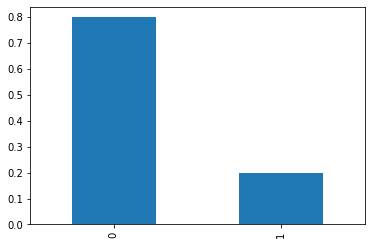

In [23]:
print(target_train.value_counts(normalize=True).plot(kind='bar'))

**Явный дисбаланс, будем лечить!**

In [24]:
#Напишем функцию которая автоматически балансирует классы
def upsampling(features_train,target_train, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * int(repeat))
    target_upsampled = pd.concat([target_zeros] + [target_ones] * int(repeat))
    features_train = shuffle(features_upsampled, random_state=12345)
    target_train = shuffle(target_upsampled, random_state=12345)
    return features_train, target_train

In [25]:
features_train, target_train = upsampling(features_train, target_train, 4)


print(features_train[target_train == 0].shape)
print(features_train[target_train == 1].shape)
print(target_train[target_train == 0].shape)
print(target_train[target_train == 1].shape)

(5998, 11)
(6008, 11)
(5998,)
(6008,)


AxesSubplot(0.125,0.125;0.775x0.755)


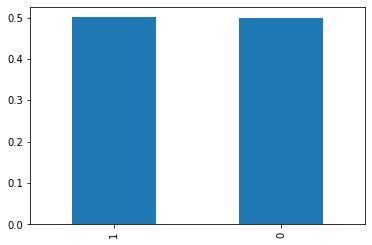

In [26]:
print(target_train.value_counts(normalize=True).plot(kind='bar'))

**Другое дело!**

**Теперь можно опять пробовать предсказывать**

In [27]:
model = LogisticRegression(random_state=12345, max_iter=1000, solver='liblinear', penalty='l1', class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)


f1 = f1_score(target_test, predicted_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'f1:{f1},roc_auc:{auc_roc}')

f1:0.5053619302949062,roc_auc:0.7632474851965472


**Подберем гиперпараметры алгоритмам РЕШАЮЩЕГО ДЕРЕВА и СЛУЧАЙНОГО ЛЕСА при помощи ГРИД СЁЧА**

In [28]:

params_dt = {"random_state":[12345],
             "max_depth": range(1,16,1),
             "class_weight":['balanced']}
model_dt = DecisionTreeClassifier()


grid_dt = GridSearchCV(estimator=model_dt, param_grid=params_dt, scoring='f1')


grid_dt.fit(features_train,target_train)

print(f'dt = {grid_dt.best_params_}')


dt = {'class_weight': 'balanced', 'max_depth': 15, 'random_state': 12345}


In [29]:
params_rfc = {"random_state":[12345],
             "n_estimators": range(10,110,10),
             "max_depth": range(1,16,1),
             "class_weight":['balanced']}


model_rfc =RandomForestClassifier()


grid_rfc = GridSearchCV(estimator=model_rfc, param_grid=params_rfc, scoring='f1')


grid_rfc.fit(features_train,target_train)

print(f'rfc = {grid_rfc.best_params_}')

rfc = {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 90, 'random_state': 12345}


In [30]:
params_rfc = {"random_state":[12345],
             "n_estimators": range(10,110,10),
             "max_depth": range(1,16,1),
             "class_weight":['balanced']}

model_rfc =RandomForestClassifier()


grid_rfc = RandomizedSearchCV(estimator=model_rfc, param_distributions=params_rfc, scoring='f1')


grid_rfc.fit(features_train,target_train)

print(f'rfc = {grid_rfc.best_params_}')

rfc = {'random_state': 12345, 'n_estimators': 40, 'max_depth': 15, 'class_weight': 'balanced'}


**Строим прогноз с гиперпараметрами подобранными грид сёчем**

In [31]:
model_dt_cv = DecisionTreeClassifier(max_depth= 15, random_state= 12345, class_weight='balanced')

model_dt_cv.fit(features_train, target_train)

predicted_test_dt = model_dt_cv.predict(features_test)




f1_dt = f1_score(target_test, predicted_test_dt)

probabilities_test_dt_cv = model_dt_cv.predict_proba(features_test)

probabilities_one_test_dt_cv = probabilities_test_dt_cv[:,1]

auc_roc_dt_cv = roc_auc_score(target_test, probabilities_one_test_dt_cv)

print(f'DT - f1:{f1_dt},roc_auc:{auc_roc_dt_cv}')


DT - f1:0.5097345132743363,roc_auc:0.6962340966921121


In [32]:

model_rfc_cv_1 =RandomForestClassifier(max_depth= 15, n_estimators= 90, random_state= 12345, class_weight='balanced')

model_rfc_cv_1.fit(features_train, target_train)

predicted_test_rfc_cv = model_rfc_cv_1.predict(features_test)



f1_rfc = f1_score(target_test, predicted_test_rfc_cv)

probabilities_test_rfc_cv = model_rfc_cv_1.predict_proba(features_test)


probabilities_one_test_rfc_cv = probabilities_test_rfc_cv[:,1]

auc_roc_rfc_cv = roc_auc_score(target_test, probabilities_one_test_rfc_cv)

print(f'RFC - f1:{f1_rfc},roc_auc:{auc_roc_rfc_cv}')


RFC - f1:0.6264822134387352,roc_auc:0.8541680340538871


**Строим прогноз с гиперпараметрами подобранными рандомайзд сёчем**

In [34]:

model_rfc_cv_1 =RandomForestClassifier(max_depth= 15, n_estimators= 40, random_state= 12345, class_weight='balanced')

model_rfc_cv_1.fit(features_train, target_train)

predicted_test_rfc_cv = model_rfc_cv_1.predict(features_test)



f1_rfc = f1_score(target_test, predicted_test_rfc_cv)

probabilities_test_rfc_cv = model_rfc_cv_1.predict_proba(features_test)


probabilities_one_test_rfc_cv = probabilities_test_rfc_cv[:,1]

auc_roc_rfc_cv = roc_auc_score(target_test, probabilities_one_test_rfc_cv)

print(f'RFC - f1:{f1_rfc},roc_auc:{auc_roc_rfc_cv}')


RFC - f1:0.6176470588235294,roc_auc:0.8469677296616013


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:** Лучше всех себя показал алгоритм СЛУЧАЙНОГО ЛЕСА с глубиной равной 15 и колличеством деревьев 80. 

Его метрики составили - 0.6265520534861508, roc_auc:0.8560956933247723


## Проверка на лучшей модели на тестовой выборке<a id="checking_on_a_test_sample"></a>

## Общий вывод<a id="resume"></a>

**ИТОГО:** Немного предобработки. Попрактиковались в масштабировании и устранении балланса классов. Посмотрели разницу в качестве предсказаний на данных одного масштаба со сбалансированными классами и без баланса классов.


Я еще делал то же самое без upsampling'а, а просто добавив гиперпараметр class_weight = 'balanced' к моделям, вышло плюс-минус то же самое.

